# *Upload datasets*


In [ ]:
import pandas as pd
import io
from google.colab import files
uploaded = files.upload()

df_train = pd.read_csv(io.BytesIO(uploaded["exoTrain.csv"]))
# Drop the null columns where all values are null
df_train = df_train.dropna(axis='columns', how='all')

# Drop the null rows
df_train = df_train.dropna()

df_train.head()

Saving exoTrain.csv to exoTrain (3).csv


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,...,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,-207.47,-154.88,-173.71,-146.56,-120.26,-102.85,-98.71,-48.42,-86.57,-0.84,-25.85,-67.39,-36.55,-87.01,-97.72,-131.59,-134.80,-186.97,-244.32,-225.76,-229.60,-253.48,-145.74,-145.74,30.47,-173.39,-187.56,-192.88,-182.76,...,-167.69,-56.86,7.56,37.40,-81.13,-20.10,-30.34,-320.48,-320.48,-287.72,-351.25,-70.07,-194.34,-106.47,-14.80,63.13,130.03,76.43,131.90,-193.16,-193.16,-89.26,-17.56,-17.31,125.62,68.87,100.01,-9.60,-25.39,-16.51,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,-86.51,-74.97,-73.15,-86.13,-76.57,-61.27,-37.23,-48.53,-30.96,-8.14,-5.54,15.79,45.71,10.61,40.66,16.70,15.18,11.98,-203.70,19.13,19.13,19.13,19.13,19.13,17.02,-8.50,-13.87,-29.10,-34.29,...,-36.75,-15.49,-13.24,20.46,-1.47,-0.40,27.80,-58.20,-58.20,-72.04,-58.01,-30.92,-13.42,-13.98,-5.43,8.71,1.80,36.59,-9.80,-19.53,-19.53,-24.32,-23.88,-33.07,-9.03,3.75,11.61,-12.66,-5.69,12.53,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,469.66,462.30,492.23,441.20,483.17,481.28,535.31,554.34,562.80,540.14,576.34,551.67,556.69,550.86,577.33,562.08,577.97,530.67,553.27,538.33,527.17,532.50,273.66,273.66,292.39,298.44,252.64,233.58,171.41,...,-51.09,-33.30,-61.53,-89.61,-69.17,-86.47,-140.91,-84.20,-84.20,-89.09,-55.44,-61.05,-29.17,-63.80,-57.61,2.70,-31.25,-47.09,-6.53,14.00,14.00,-25.05,-34.98,-32.08,-17.06,-27.77,7.86,-70.77,-64.44,-83.83,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,311.14,326.19,313.11,313.89,317.96,330.92,341.10,360.58,370.29,369.71,339.00,336.24,319.31,321.56,308.02,296.82,279.34,275.78,289.67,281.33,285.37,281.87,88.75,88.75,67.71,74.46,69.34,76.51,80.26,...,-2.75,14.29,-14.18,-25.14,-13.43,-14.74,2.24,-31.07,-31.07,-50.27,-39.22,-51.33,-18.53,-1.99,10.43,-1.97,-15.32,-23.38,-27.71,-36.12,-36.12,-15.65,6.63,10.66,-8.57,-8.29,-21.90,-25.80,-29.86,7.42,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,-933.30,-889.49,-888.66,-853.95,-800.91,-754.48,-717.24,-649.34,-605.71,-575.62,-526.37,-490.12,-458.73,-447.76,-419.54,-410.76,-404.10,-425.38,-397.29,-412.73,-446.49,-413.46,-1006.21,-1006.21,-973.29,-986.01,-975.88,-982.20,-953.73,...,-694.76,-705.01,-625.24,-604.16,-668.26,-742.18,-820.55,-874.76,-874.76,-853.68,-808.62,-777.88,-712.62,-694.01,-655.74,-599.74,-617.30,-602.98,-539.29,-672.71,-672.71,-594.49,-597.60,-560.77,-501.95,-461.62,-468.59,-513.24,-504.70,-521.95,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [ ]:
uploaded = files.upload()
df_test=pd.read_csv(io.BytesIO(uploaded["exoTest.csv"]))
df_test = df_test.dropna(axis='columns', how='all')
df_test = df_test.dropna()
df_test.head()


Saving exoTest.csv to exoTest.csv


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,...,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,-21.97,-23.17,-29.26,-33.99,-6.25,-28.12,-27.24,-32.28,-12.29,-16.57,-23.86,-5.69,9.24,35.52,81.20,116.49,133.99,148.97,174.15,187.77,215.30,246.80,-56.68,-56.68,-56.68,-52.05,-31.52,-31.15,-48.53,-38.93,...,-2.55,12.26,-7.06,-23.53,2.54,30.21,38.87,-22.86,-22.86,-4.37,2.27,-16.27,-30.84,-7.21,-4.27,13.60,15.62,31.96,49.89,86.93,86.93,42.99,48.76,22.82,32.79,30.76,14.55,10.92,22.68,5.91,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,5458.80,5329.39,5191.38,5031.39,4769.89,4419.66,4218.92,3924.73,3605.30,3326.55,3021.20,2800.61,2474.48,2258.33,1951.69,1749.86,1585.38,1575.48,1568.41,1661.08,1977.33,2425.62,2889.61,3847.64,3847.64,3741.20,3453.47,3202.61,2923.73,2694.84,...,-3470.75,-4510.72,-5013.41,-3636.05,-2324.27,-2688.55,-2813.66,-586.22,-586.22,-756.80,-1090.23,-1388.61,-1745.36,-2015.28,-2359.06,-2516.66,-2699.31,-2777.55,-2732.97,1167.39,1167.39,1368.89,1434.80,1360.75,1148.44,1117.67,714.86,419.02,57.06,-175.66,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,150.46,85.49,-20.12,-35.88,-65.59,-15.12,16.60,-25.70,61.88,53.18,64.32,72.38,100.35,67.26,14.71,-16.41,-147.46,-231.27,-320.29,-407.82,-450.48,-146.99,-146.99,-146.99,-146.99,-166.30,-139.90,-96.41,-23.49,13.59,...,-35.24,-70.13,-35.30,-56.48,-74.60,-115.18,-8.91,-37.59,-37.59,-37.43,-104.23,-101.45,-107.35,-109.82,-126.27,-170.32,-117.85,-32.30,-70.18,314.29,314.29,314.29,149.71,54.60,12.60,-133.68,-78.16,-52.30,-8.55,-19.73,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,-679.56,-706.03,-720.56,-631.12,-659.16,-672.03,-665.06,-667.94,-660.84,-672.75,-644.91,-680.53,-620.50,-570.34,-530.00,-537.88,-578.38,-532.34,-532.38,-491.03,-485.03,-427.19,-380.84,-329.50,-286.91,-283.81,-298.19,-271.03,-268.50,-209.56,...,16.50,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-1286.59,-14.94,64.09,8.38,45.31,100.72,91.53,46.69,20.34,30.94,-36.81,-33.28,-69.62,-208.00,-280.28,-340.41,-337.41,-268.03,-245.00,-230.62,-129.59,-35.47,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,14.62,-19.52,-11.43,-49.80,25.84,11.62,3.18,-9.59,14.49,8.82,32.32,-28.90,-28.90,-14.09,-30.87,-18.99,-38.60,-27.79,9.65,29.60,7.88,42.87,27.59,27.05,20.26,29.48,9.71,22.84,25.99,-667.55,...,-122.12,-32.01,-47.15,-56.45,-41.71,-34.13,-43.12,-53.63,-53.63,-53.63,-24.29,22.29,25.18,1.84,-22.29,-26.43,-12.12,-33.05,-21.66,-228.32,-228.32,-228.32,-187.35,-166.23,-115.54,-50.18,-37.96,-22.37,-4.74,-35.82,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84


In [ ]:
# Generate X and Y dataframe sets
df_train_x = df_train.drop('LABEL', axis=1)
df_test_x = df_test.drop('LABEL', axis=1)
# remove y values from x ,separate
df_train_y = df_train.LABEL
df_test_y = df_test.LABEL

# *Plot two different instances, confirmed planet and non confirmed*

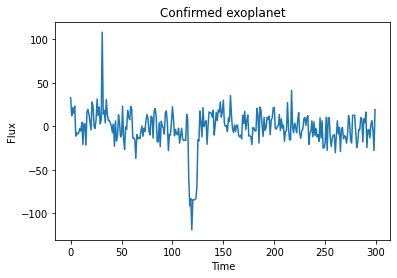

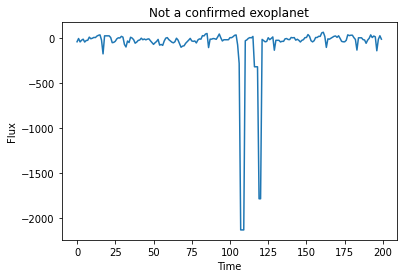

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_series(series, title):
    plt.plot(np.arange(len(series)), series)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.show()  
plot_series(df_train.iloc[6, 200:500], 'Confirmed exoplanet')
plot_series(df_train.iloc[100, 2600:2800], 'Not a confirmed exoplanet')
#source:https://www.kaggle.com/tomgglynnejones/cnn-based-on-google-kepler-approach

# *LightCurve data Preprocessing*

In [9]:

# Applying Fast Fourier Transform (FFT)
def fourier_transform(df):
    df_fft = np.abs(np.fft.fft(df, axis=1))
    return df_fft

# Handling upper outliers: personalized function
def reduce_upper_outliers(df,reduce = 0.01, half_width=4):
    length = len(df.iloc[0,:])
    remove = int(length*reduce)
    for i in df.index.values: #Para cada muestra
        values = df.loc[i,:]
        sorted_values = values.sort_values(ascending = False)
        for j in range(remove): 
            idx = sorted_values.index[j]
            new_val = 0
            count = 0
            idx_num = int(idx[5:])
            for k in range(2*half_width+1):
                idx2 = idx_num + k - half_width
                if idx2 <1 or idx2 >= length or idx_num == idx2:
                    continue
                new_val += values['FLUX.'+str(idx2)]

                count += 1
            new_val /= count # count will always be positive here
            if new_val < values[idx]: # just in case there's a few persistently high adjacent values
                df.at[i,idx] = new_val
    return df

def iterar_ruo(df, n=2):
    for i in range(n): 
        df2 = reduce_upper_outliers(df)
    return df2

# Handling outliers: Smoothing filters
def apply_filter(df,filternumber):
    #UNIFORM FILTER == 0
    if filternumber == 0:
            filt = uniform_filter1d(df, axis=1, size=50)
    #GAUSSIAN FILTER == 1
    elif filternumber == 1:
        filt = ndimage.filters.gaussian_filter(df, sigma=10)
    #Savitzky-Golay FILTER == 2
    elif filternumber == 2:
        filt = savgol_filter(df,21,4,deriv=0)

    return filt

# Normalizing data
def apply_normalization(df_train, df_test, nnumber):
    #MinMax Scaler
    if nnumber == 0:
        scaler = MinMaxScaler()
        norm_train = scaler.fit_transform(df_train)
        norm_test = scaler.transform(df_test)
    #Normalize
    elif nnumber == 1:
        norm_train = normalize(df_train)
        norm_test = normalize(df_test)
    elif nnumber == 2:
        scaler = RobustScaler()
        norm_train = scaler.fit_transform(df_train)
        norm_test = scaler.transform(df_test)
        
    
    norm_train = pd.DataFrame(norm_train)
    norm_test = pd.DataFrame(norm_test)
    return norm_train, norm_test

# Standardizing data
def apply_standarization(df_train, df_test):
    scaler = StandardScaler()
    norm_train = scaler.fit_transform(df_train)
    norm_test = scaler.transform(df_test)
    
    norm_train = pd.DataFrame(norm_train)
    norm_test = pd.DataFrame(norm_test)

    return norm_train, norm_test
#sources: 1-https://github.com/gabrielgarza/exoplanet-deep-learning/blob/master/notebook.ipynb
# 2- https://www.kaggle.com/danihinjos/perfect-classification-with-cnn-100-metrics/notebook

In [10]:
#create a class to preprocess lightcurve data
# source: https://github.com/gabrielgarza/exoplanet-deep-learning/blob/master/notebook.ipynb
import pandas as pd
import numpy as np
from scipy import ndimage, fft
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler

class dataProcessor:

    def __init__(self, outlier=False, smoothing=False, fourier=False, normalize=False, standardize=False):
        self.outlier = outlier
        self.smoothing = smoothing
        self.normalize = normalize
        self.standardize = standardize
        self.fourier = fourier
    
    def process(self, df_train_x, df_test_x):
        
        # Handling outliers
        if self.outlier:
            print("Removing upper outliers...")
            df_train_x = iterar_ruo(df_train_x, P_OUTLIERS)
            df_test_x = iterar_ruo(df_test_x, P_OUTLIERS)
            
        # Apply fourier transform
        if self.fourier:
            print("Applying Fourier...")
            df_train_x = fourier_transform(df_train_x)
            df_test_x = fourier_transform(df_test_x)
        
        # Applying smoothing filters
        if self.smoothing:
            print("Applying smoothing filter...")
            df_train_x = pd.DataFrame(apply_filter(df_train_x, FILTER_NUMBER))
            df_test_x = pd.DataFrame(apply_filter(df_test_x, FILTER_NUMBER))
            
        # Normalization
        if self.normalize:
            print("Normalizing...")
            df_train_x, df_test_x = apply_normalization(df_train_x, df_test_x, TIPO_NORM)
            
        # Standardization
        if self.standardize:
            print("Standardizing...")
            df_train_x, df_test_x = apply_standarization(df_train_x, df_test_x)
        

        print("Finished Processing!")
        return df_train_x, df_test_x


In [11]:
P_OUTLIERS = 2
FILTER_NUMBER = 1
TIPO_NORM = 1

Processor = dataProcessor(
    outlier = True,
    fourier = True,
    smoothing = True,
    normalize= True,
    standardize= True )

df_train_x, df_test_x = Processor.process(df_train_x, df_test_x)

Removing upper outliers...
Applying Fourier...
Applying smoothing filter...
Normalizing...
Standardizing...
Finished Processing!


# *Build CNN* 

In [12]:
    
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from keras import metrics
from keras.callbacks import ModelCheckpoint

from imblearn.over_sampling import SMOTE

from pathlib import Path

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import math
import time
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report

from  scipy import ndimage, fft
from sklearn.preprocessing import normalize
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Convolution1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

In [13]:
#Scaling
sc = StandardScaler()
df_train_x = sc.fit_transform(df_train_x)
df_test_x = sc.fit_transform(df_test_x)
#Converting data into 3D tensor
df_train_x = np.reshape(df_train_x,(df_train_x.shape[0],df_train_x.shape[1],1))
df_test_x = np.reshape(df_test_x,(df_test_x.shape[0],df_test_x.shape[1],1))

In [16]:
classifier = Sequential()
classifier.add(Convolution1D(filters=8, kernel_size=11, activation="relu", input_shape=(3197,1)))
classifier.add(MaxPooling1D(strides=4))
classifier.add(BatchNormalization())
classifier.add(Flatten())
classifier.add(Dropout(0.5))
classifier.add(Dense(64, activation='relu'))
classifier.add(Dropout(0.25))
classifier.add(Dense(64, activation='relu'))
classifier.add(Dense(1, activation='sigmoid'))
classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

classifier.fit(df_train_x, df_train_y, batch_size=32, epochs=1, validation_data=(df_test_x,df_test_y))
score = classifier.evaluate(df_test_x, df_test_y)


18/18 [==============================] - 0s 18ms/step - loss: -14.2738 - accuracy: 0.9912 - precision: 1.0000 - recall: 1.0000
